In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
import re
import string

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

In [3]:
true_data['target'] = 1
fake_data['target'] = 0

In [4]:
combined = pd.concat([true_data,fake_data],axis = 'rows')

In [5]:
combined

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [6]:
combined = combined.sample(frac = 1).reset_index(drop = True)

In [7]:
combined.head(5)

,title,text,subject,date,target
0,Ramaphosa's ANC election win lifts South Afric...,JOHANNESBURG (Reuters) - South African banking...,worldnews,"December 19, 2017",1
1,VIGILANTE PIRATES INTERCEDE Where Government F...,Like the Soldiers of Oden vigilante group we r...,Government News,"Apr 1, 2016",0
2,"SICK! DEMOCRAT ORGANIZER, Mayor DeBlasio Emplo...",Last week it was Huma Abedin s husband Anthony...,left-news,"May 28, 2017",0
3,Dennis Rodman talks of skiing friendship with ...,EDINBURGH (Reuters) - U.S. basketball legend D...,worldnews,"September 6, 2017",1
4,New Hampshire Cops Intent On Protecting Sadis...,"It s 2017, and lynchings of black people still...",News,"September 10, 2017",0


In [8]:
combined.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

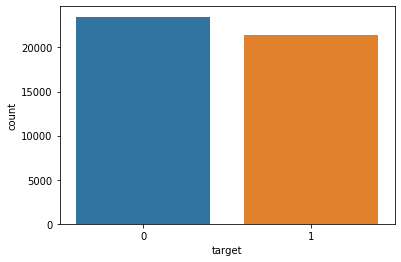

In [9]:
sns.countplot(x = 'target',data = combined)

## subject column

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

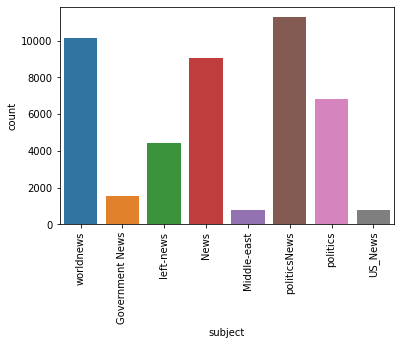

In [10]:
sns.countplot(x = combined['subject'])
plt.xticks(rotation = 90)

## Text Data Preprocessing

In [11]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

combined['text'] = combined['text'].apply(lambda x : clean_text(x))

In [12]:
#Tokenization

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

combined['text'] = combined['text'].apply(lambda x : tokenizer.tokenize(x))

combined.head(5)

,title,text,subject,date,target
0,Ramaphosa's ANC election win lifts South Afric...,"[johannesburg, reuters, south, african, bankin...",worldnews,"December 19, 2017",1
1,VIGILANTE PIRATES INTERCEDE Where Government F...,"[like, the, soldiers, of, oden, vigilante, gro...",Government News,"Apr 1, 2016",0
2,"SICK! DEMOCRAT ORGANIZER, Mayor DeBlasio Emplo...","[last, week, it, was, huma, abedin, s, husband...",left-news,"May 28, 2017",0
3,Dennis Rodman talks of skiing friendship with ...,"[edinburgh, reuters, us, basketball, legend, d...",worldnews,"September 6, 2017",1
4,New Hampshire Cops Intent On Protecting Sadis...,"[it, s, and, lynchings, of, black, people, sti...",News,"September 10, 2017",0


In [18]:
#Stopwords removal

i = 0
def remove_stopwords(text):
    global i
    words = [w for w in text if w not in stopwords.words('english')]
    i+=1
    
    if(i%1000==0):
        print("Processed ",i," rows")
    
    return words

combined['text'] = combined['text'].apply(lambda x : remove_stopwords(x))

combined.head(5)

Processed  1000  rows
Processed  2000  rows
Processed  3000  rows
Processed  4000  rows
Processed  5000  rows
Processed  6000  rows
Processed  7000  rows
Processed  8000  rows
Processed  9000  rows
Processed  10000  rows
Processed  11000  rows
Processed  12000  rows
Processed  13000  rows
Processed  14000  rows
Processed  15000  rows
Processed  16000  rows
Processed  17000  rows
Processed  18000  rows
Processed  19000  rows
Processed  20000  rows
Processed  21000  rows
Processed  22000  rows
Processed  23000  rows
Processed  24000  rows
Processed  25000  rows
Processed  26000  rows
Processed  27000  rows
Processed  28000  rows
Processed  29000  rows
Processed  30000  rows
Processed  31000  rows
Processed  32000  rows
Processed  33000  rows
Processed  34000  rows
Processed  35000  rows
Processed  36000  rows
Processed  37000  rows
Processed  38000  rows
Processed  39000  rows
Processed  40000  rows
Processed  41000  rows
Processed  42000  rows
Processed  43000  rows
Processed  44000  ro

,title,text,subject,date,target
0,Ramaphosa's ANC election win lifts South Afric...,"[johannesburg, reuters, south, african, bankin...",worldnews,"December 19, 2017",1
1,VIGILANTE PIRATES INTERCEDE Where Government F...,"[like, soldiers, oden, vigilante, group, repor...",Government News,"Apr 1, 2016",0
2,"SICK! DEMOCRAT ORGANIZER, Mayor DeBlasio Emplo...","[last, week, huma, abedin, husband, anthony, w...",left-news,"May 28, 2017",0
3,Dennis Rodman talks of skiing friendship with ...,"[edinburgh, reuters, us, basketball, legend, d...",worldnews,"September 6, 2017",1
4,New Hampshire Cops Intent On Protecting Sadis...,"[lynchings, black, people, still, happen, jim,...",News,"September 10, 2017",0


In [21]:
#Token normalization

def combine_text(listoftext):
    
    combined_text = ' '.join(listoftext)
    return combined_text

combined['text'] = combined['text'].apply(lambda x : combine_text(x))

combined.head(5)

,title,text,subject,date,target
0,Ramaphosa's ANC election win lifts South Afric...,johannesburg reuters south african banking sto...,worldnews,"December 19, 2017",1
1,VIGILANTE PIRATES INTERCEDE Where Government F...,like soldiers oden vigilante group reported fe...,Government News,"Apr 1, 2016",0
2,"SICK! DEMOCRAT ORGANIZER, Mayor DeBlasio Emplo...",last week huma abedin husband anthony weiner w...,left-news,"May 28, 2017",0
3,Dennis Rodman talks of skiing friendship with ...,edinburgh reuters us basketball legend dennis ...,worldnews,"September 6, 2017",1
4,New Hampshire Cops Intent On Protecting Sadis...,lynchings black people still happen jim crow c...,News,"September 10, 2017",0


In [20]:
combined.to_csv("train_nostopwords_combined.csv")

# Tokens to Vector - Bag of words

In [23]:
count_vectorizer = CountVectorizer()
eval_vectors = count_vectorizer.fit_transform(combined['text'])

### TFIDF Features

In [36]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range =(1,2))
eval_tfidf = tfidf.fit_transform(combined['text'])

# Text Classifier

In [33]:
clf = LogisticRegression(C = 1.0)
scores = model_selection.cross_val_score(clf, eval_vectors, 
                                         combined['target'],
                                         cv = 5, scoring = 'f1')
print(scores)
print(sum(scores)/5)

[0.99603082 0.99626517 0.99824828 0.99521419 0.99626517]
0.9964047272927266


In [38]:
clf_tfidf = LogisticRegression(C = 1.0)
scores_tfidf = model_selection.cross_val_score(clf_tfidf, eval_tfidf, 
                                         combined['target'],
                                        cv = 5, scoring = 'f1')
print(scores_tfidf)
print(sum(scores)/5)

[0.98524936 0.98671329 0.98646125 0.98577425 0.9855174 ]
0.9859431100421017


In [14]:
dummy_test = pd.read_csv('DummyTest.csv',encoding = "ISO-8859-1")

In [15]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

dummy_test['text'] = dummy_test['text'].apply(lambda x : clean_text(x))


#Tokenization

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

dummy_test['text'] = dummy_test['text'].apply(lambda x : tokenizer.tokenize(x))


#Stopwords removal

i = 0
def remove_stopwords(text):
    global i
    words = [w for w in text if w not in stopwords.words('english')]
    i+=1
    
    if(i%100==0):
        print("Processed ",i," rows")
    
    return words

dummy_test['text'] = dummy_test['text'].apply(lambda x : remove_stopwords(x))

dummy_test.head(5)

Processed  100  rows
Processed  200  rows
Processed  300  rows
Processed  400  rows
Processed  500  rows
Processed  600  rows
Processed  700  rows
Processed  800  rows


,article_title,text,location,target
0,Syria attack symptoms consistent with nerve ag...,"[wed, apr, syria, attack, symptoms, consistent...",idlib,0
1,Homs governor says U.S. attack caused deaths b...,"[fri, apr, homs, governor, says, us, attack, c...",homs,0
2,Death toll from Aleppo bomb attack at least 112,"[sun, apr, death, toll, aleppo, bomb, attack, ...",aleppo,0
3,Aleppo bomb blast kills six Syrian state TV,"[wed, apr, aleppo, bomb, blast, kills, six, sy...",aleppo,0
4,29 Syria Rebels Dead in Fighting for Key Alepp...,"[sun, jul, syria, rebels, dead, fighting, key,...",aleppo,0


In [16]:
#Token normalization

def combine_text(listoftext):
    
    combined_text = ' '.join(listoftext)
    return combined_text

dummy_test['text'] = dummy_test['text'].apply(lambda x : combine_text(x))

dummy_test.head(5)

,article_title,text,location,target
0,Syria attack symptoms consistent with nerve ag...,wed apr syria attack symptoms consistent nerve...,idlib,0
1,Homs governor says U.S. attack caused deaths b...,fri apr homs governor says us attack caused de...,homs,0
2,Death toll from Aleppo bomb attack at least 112,sun apr death toll aleppo bomb attack least de...,aleppo,0
3,Aleppo bomb blast kills six Syrian state TV,wed apr aleppo bomb blast kills six syrian sta...,aleppo,0
4,29 Syria Rebels Dead in Fighting for Key Alepp...,sun jul syria rebels dead fighting key aleppo ...,aleppo,0


In [5]:
dummy_test.to_csv("testnostopwords.csv",index = False)

In [57]:
test_vectors = count_vectorizer.transform(dummy_test['text'])

In [58]:
test_tfidf = tfidf.transform(dummy_test['text'])

In [69]:
clf = LogisticRegression(C = 1.0)
scores = model_selection.cross_val_score(clf, eval_vectors, 
                                         combined['target'],
                                         cv = 5, scoring = 'f1')
print(scores)
print(sum(scores)/5)

[0.99603082 0.99626517 0.99824828 0.99521419 0.99626517]
0.9964047272927266


In [59]:
clf.fit(eval_vectors, combined['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
y_test = dummy_test['labels']
preds = clf.predict(test_vectors)

In [64]:
#from sklearn.metrics import f1_score

print(f1_score(y_test,preds))

0.4725415070242656


In [71]:
clf_tfidf.fit(eval_tfidf,combined['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
pred_tfidf = clf_tfidf.predict(test_tfidf)
print(f1_score(dummy_test['labels'],pred_tfidf))

0.6387035271687321
